<a href="https://colab.research.google.com/github/LatiefDataVisionary/deep-learning-college-task/blob/main/tasks/week_5_tasks/Task_ViT_HuggingFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Section 0: Initial Setup (Pengaturan Awal)**

**Penjelasan:** Bagian ini untuk melakukan instalasi library penting yang mungkin belum ada di Colab dan menghubungkan Google Drive.

### **0.1. Install Libraries (Instalasi Library)**

**Penjelasan:** Menginstal library tambahan yang mungkin diperlukan, yaitu `mtcnn` yang merupakan library kunci untuk deteksi wajah.

In [28]:
# Install mtcnn library
!pip install opencv

ERROR: Could not find a version that satisfies the requirement opencv (from versions: none)
ERROR: No matching distribution found for opencv


### **0.2. Mount Google Drive (Menghubungkan Google Drive**)

**Penjelasan:** Menghubungkan notebook ini dengan akun Google Drive Anda. Ini diperlukan agar notebook dapat membaca file dataset gambar yang telah Anda simpan di Google Drive. Setelah menjalankan sel ini, ikuti instruksi otorisasi yang muncul.

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Section 1: Import Libraries and Environment Setup (Impor Library dan Pengaturan Lingkungan)**

**Penjelasan:** Mengimpor semua modul yang dibutuhkan dan mendefinisikan variabel-variabel global, termasuk path untuk data mentah dan data yang akan diproses.

### **1.1. Import Core Libraries (Impor Library Utama)**

**Penjelasan:** Mengimpor library utama seperti tensorflow, keras, numpy, matplotlib, os, zipfile, cv2 (OpenCV), glob, shutil yang akan digunakan sepanjang proyek ini.

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
import cv2 # Import OpenCV
import glob # To list files
import shutil # To manage directories
import random
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns # For confusion matrix visualization

### **1.2. Define Configurations (Definisi Konfigurasi)**

**Penjelasan:** Mendefinisikan variabel-variabel konfigurasi yang akan digunakan di seluruh notebook, termasuk path ke dataset, ukuran gambar yang akan digunakan, ukuran batch untuk training, jumlah epoch, dan jumlah kelas (mahasiswa).

In [31]:
# Define Directory Paths (Definisi Path Direktori)
# Path ke file zip di Google Drive
ZIP_PATH = '/content/drive/MyDrive/Dataset/Dataset Sistem Presensi Wajah V1.0.zip'
# Path untuk mengekstrak data mentah (sebelum deteksi wajah)
RAW_DATA_PATH = '/content/raw_dataset'
# Path untuk menyimpan dataset yang sudah bersih (setelah deteksi wajah)
PROCESSED_PATH = '/content/processed_dataset'

# Define Image Parameters (Definisi Parameter Gambar)
IMG_HEIGHT = 128 # Ukuran yang lebih kecil cocok untuk model dari dasar
IMG_WIDTH = 128
CHANNELS = 3 # RGB color images

# Define Training Parameters (Definisi Parameter Pelatihan)
BATCH_SIZE = 32
EPOCHS = 50 # Will be controlled by Early Stopping
# NUM_CLASSES will be determined by the data generator later
NUM_CLASSES = None # Placeholder

## **Section 2: Advanced Preprocessing - Face Detection and Cropping (Preprocessing Lanjutan - Deteksi dan Pemotongan Wajah)**

**Penjelasan:** Ini adalah tahap paling krusial dan merupakan upgrade utama. Kita akan memproses seluruh dataset mentah sekali jalan. Tujuannya adalah mendeteksi wajah di setiap gambar, memotongnya, dan menyimpannya ke struktur direktori baru yang bersih dan siap pakai. Ini menyelesaikan masalah distorsi aspect ratio dan noise latar belakang menggunakan deteksi wajah berbasis OpenCV Haar Cascades.

### **2.1. Unzip Raw Dataset (Ekstrak Dataset Mentah)**

**Penjelasan:** Kode untuk mengekstrak file .zip ke RAW_DATA_PATH.

In [32]:
print(f"Extracting {ZIP_PATH} to {RAW_DATA_PATH}...")
try:
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(RAW_DATA_PATH)
    print("Extraction complete.")
except FileNotFoundError:
    print(f"Error: Zip file not found at {ZIP_PATH}")
except zipfile.BadZipFile:
    print(f"Error: Could not open or read zip file at {ZIP_PATH}. It might be corrupted.")
except Exception as e:
    print(f"An error occurred during extraction: {e}")

# Verify extraction
if os.path.exists(RAW_DATA_PATH):
    print(f"\nContents of {RAW_DATA_PATH} after extraction: {os.listdir(RAW_DATA_PATH)}")
else:
    print(f"\nError: Raw data directory not found after extraction at {RAW_DATA_PATH}")

# Assuming the extracted content is in a subfolder within RAW_DATA_PATH
# Let's find the actual folder containing the images
raw_image_folder = None
for item in os.listdir(RAW_DATA_PATH):
    item_path = os.path.join(RAW_DATA_PATH, item)
    if os.path.isdir(item_path):
        # Simple check: if it contains subfolders or files ending with .jpg
        if any(os.path.isdir(os.path.join(item_path, sub_item)) for sub_item in os.listdir(item_path)) or \
           any(sub_item.endswith('.jpg') for sub_item in os.listdir(item_path)):
           raw_image_folder = item_path
           break

if raw_image_folder:
    print(f"\nIdentified raw image folder: {raw_image_folder}")
    # Update RAW_DATA_PATH to point directly to the folder containing the images
    RAW_DATA_PATH = raw_image_folder
    print(f"Updated RAW_DATA_PATH: {RAW_DATA_PATH}")
else:
    print("\nWarning: Could not identify the main folder containing raw images within the extracted directory.")
    print("Please manually inspect the extracted contents and update RAW_DATA_PATH if necessary.")

Extracting /content/drive/MyDrive/Dataset/Dataset Sistem Presensi Wajah V1.0.zip to /content/raw_dataset...
Extraction complete.

Contents of /content/raw_dataset after extraction: ['Dataset Sistem Presensi Wajah V1.0']

Identified raw image folder: /content/raw_dataset/Dataset Sistem Presensi Wajah V1.0
Updated RAW_DATA_PATH: /content/raw_dataset/Dataset Sistem Presensi Wajah V1.0


### **2.2. Initialize Face Detector (OpenCV Haar Cascade)**

**Penjelasan:** Memuat file Haar Cascade pre-trained untuk deteksi wajah dari OpenCV. Kita akan menggunakan detektor wajah frontal default.

In [33]:
# Remove the Haar Cascade XML file loading as we are no longer using it
# haar_cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'

# Remove the check and initialization
# if not os.path.exists(haar_cascade_path):
#     print(f"Error: Haar Cascade file not found at {haar_cascade_path}")
#     print("You might need to find its location or download it manually.")
#     face_cascade = None # Set cascade to None if file is not found
# else:
#     # Initialize the Haar Cascade face detector
#     face_cascade = cv2.CascadeClassifier(haar_cascade_path)

# if face_cascade is not None and face_cascade.empty():
#     print("Error: Failed to load Haar Cascade classifier.")
#     face_cascade = None
# else:
#     print("OpenCV Haar Cascade face detector initialized successfully.")

print("OpenCV Haar Cascade initialization skipped as face detection is being replaced by simple cropping.")
face_cascade = None # Explicitly set to None as it's not used

OpenCV Haar Cascade initialization skipped as face detection is being replaced by simple cropping.


### **2.3. Prepare Processed Directory Structure (Siapkan Struktur Direktori Hasil Proses)**

**Penjelasan:** Membuat direktori tujuan untuk data yang sudah diproses (`PROCESSED_PATH`) dan sub-direktori `train` dan `test` di dalamnya. Kemudian, mengidentifikasi kelas-kelas (mahasiswa) dari nama file mentah dan membuat sub-folder untuk setiap kelas di dalam direktori `train` dan `test` yang sudah diproses.

In [34]:
# Remove existing processed directory if it exists to start fresh
if os.path.exists(PROCESSED_PATH):
    print(f"Removing existing processed directory: {PROCESSED_PATH}")
    shutil.rmtree(PROCESSED_PATH)

# Create the main processed directory
os.makedirs(PROCESSED_PATH, exist_ok=True)

# Define train and test paths within the processed directory
PROCESSED_TRAIN_DIR = os.path.join(PROCESSED_PATH, 'train')
PROCESSED_TEST_DIR = os.path.join(PROCESSED_PATH, 'test')

# Create train and test sub-directories
os.makedirs(PROCESSED_TRAIN_DIR, exist_ok=True)
os.makedirs(PROCESSED_TEST_DIR, exist_ok=True)

print(f"Created processed directories: {PROCESSED_TRAIN_DIR} and {PROCESSED_TEST_DIR}")

# Identify class names (NIMs) from the filenames in the raw train and test directories
# We need to look inside 'Data Train' and 'Data Test' to get all NIMs
raw_train_folder = os.path.join(RAW_DATA_PATH, 'Data Train')
raw_test_folder = os.path.join(RAW_DATA_PATH, 'Data Test')

all_raw_image_files = []
# Use glob to find files with multiple extensions
if os.path.exists(raw_train_folder):
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        all_raw_image_files.extend(glob.glob(os.path.join(raw_train_folder, ext)))
if os.path.exists(raw_test_folder):
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        all_raw_image_files.extend(glob.glob(os.path.join(raw_test_folder, ext)))


# Extract unique NIMs (first 10 characters of filename)
class_nims = sorted(list(set([os.path.basename(f)[:10] for f in all_raw_image_files if len(os.path.basename(f)) >= 10])))


if not class_nims:
    print("Error: No class NIMs found based on filename format (first 10 characters) in Data Train or Data Test folders. Please check filenames.")
else:
    print(f"\nIdentified {len(class_nims)} unique classes (NIMs). Example: {class_nims[:10]}...")

    # Create class sub-folders in both train and test processed directories
    for nim in class_nims:
        os.makedirs(os.path.join(PROCESSED_TRAIN_DIR, nim), exist_ok=True)
        os.makedirs(os.path.join(PROCESSED_TEST_DIR, nim), exist_ok=True)
    print(f"\nCreated sub-folders for {len(class_nims)} classes in {PROCESSED_TRAIN_DIR} and {PROCESSED_TEST_DIR}.")

# Update NUM_CLASSES global variable
NUM_CLASSES = len(class_nims)
print(f"Updated NUM_CLASSES: {NUM_CLASSES}")

Removing existing processed directory: /content/processed_dataset
Created processed directories: /content/processed_dataset/train and /content/processed_dataset/test

Identified 53 unique classes (NIMs). Example: ['5221911012', '5221911025', '5231811002', '5231811004', '5231811005', '5231811006', '5231811007', '5231811008', '5231811009', '5231811010']...

Created sub-folders for 53 classes in /content/processed_dataset/train and /content/processed_dataset/test.
Updated NUM_CLASSES: 53


### **2.4. Run the Simple Cropping Pipeline (Jalankan Pipeline Pemotongan Sederhana)**

**Penjelasan:** Fungsi ini akan membaca gambar dari direktori sumber, melakukan pemotongan di bagian tengah gambar (simple center crop), mengubah ukurannya, dan menyimpannya ke direktori tujuan yang sudah distrukturkan per kelas. Kita akan membagi data secara manual ke direktori train/test selama proses penyimpanan. **Catatan:** Langkah ini menggantikan deteksi wajah yang lebih kompleks demi kecepatan, dengan asumsi wajah berada di tengah gambar.

In [35]:
def process_and_save_faces_by_split(raw_train_dir, raw_test_dir, processed_train_dir, processed_test_dir, img_width, img_height):
    """
    Processes images directly from raw train and test directories by performing a simple
    center crop and resize, extracting class name (NIM) from the filename,
    and saves them to the corresponding processed train and test directories
    under the correct class subfolder. Assumes filenames are in the format NIM_...jpg/png/jpeg.

    Args:
        raw_train_dir (str): Directory containing raw training images (all in one folder per split).
        raw_test_dir (str): Directory containing raw testing images (all in one folder per split).
        processed_train_dir (str): Directory to save processed training images (with class subdirectories).
        processed_test_dir (str): Directory to save processed testing images (with class subdirectories).
        img_width (int): Target width for cropped face images.
        img_height (int): Target height for cropped face images.
    """

    total_processed_train = 0
    skipped_error_train = 0

    print(f"\nStarting simple center cropping for training data from {raw_train_dir}...")

    # Process training data - iterate directly through image files
    image_files_train = []
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        image_files_train.extend(glob.glob(os.path.join(raw_train_dir, ext)))
    # print(f"Found {len(image_files_train)} images in {raw_train_dir} for training") # Debug print

    for img_path in image_files_train:
        try:
            # Read image
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Could not read image {img_path}. Skipping.")
                skipped_error_train += 1
                continue

            # Get image dimensions
            h, w, _ = img.shape

            # Determine crop dimensions (simple center crop)
            min_dim = min(h, w)
            start_x = max(0, int((w - min_dim) / 2))
            start_y = max(0, int((h - min_dim) / 2))
            end_x = start_x + min_dim
            end_y = start_y + min_dim

            # Crop the center square
            center_crop = img[start_y:end_y, start_x:end_x]

            # Resize the cropped image to the target size
            img_resized = cv2.resize(center_crop, (img_width, img_height))

            # Extract NIM (class name) from filename
            filename = os.path.basename(img_path)
            if len(filename) < 10:
                 print(f"Warning: Filename {filename} is too short to extract NIM. Skipping.")
                 skipped_error_train += 1
                 continue

            nim = filename[:10] # Assuming first 10 chars are NIM

            # Define save directory and path under the correct NIM subfolder
            save_dir = os.path.join(processed_train_dir, nim)
            os.makedirs(save_dir, exist_ok=True) # Ensure the class directory exists
            save_path = os.path.join(save_dir, filename)

            # Save the processed image
            cv2.imwrite(save_path, img_resized)
            total_processed_train += 1

        except Exception as e:
            print(f"An error occurred while processing {img_path}: {e}")
            skipped_error_train += 1
            continue

    print(f"\nSimple center cropping for training data complete.")
    print(f"Total training images processed: {total_processed_train}")
    print(f"Training images skipped (error): {skipped_error_train}")

    total_processed_test = 0
    skipped_error_test = 0

    print(f"\nStarting simple center cropping for testing data from {raw_test_dir}...")

    # Process testing data - iterate directly through image files
    image_files_test = []
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        image_files_test.extend(glob.glob(os.path.join(raw_test_dir, ext)))
    # print(f"Found {len(image_files_test)} images in {raw_test_dir} for testing") # Debug print

    for img_path in image_files_test:
        try:
            # Read image
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Could not read image {img_path}. Skipping.")
                skipped_error_test += 1
                continue

            # Get image dimensions
            h, w, _ = img.shape

            # Determine crop dimensions (simple center crop)
            min_dim = min(h, w)
            start_x = max(0, int((w - min_dim) / 2))
            start_y = max(0, int((h - min_dim) / 2))
            end_x = start_x + min_dim
            end_y = start_y + min_dim

            # Crop the center square
            center_crop = img[start_y:end_y, start_x:end_x]

            # Resize the cropped image to the target size
            img_resized = cv2.resize(center_crop, (img_width, img_height))

            # Extract NIM (class name) from filename
            filename = os.path.basename(img_path)
            if len(filename) < 10:
                 print(f"Warning: Filename {filename} is too short to extract NIM. Skipping.")
                 skipped_error_test += 1
                 continue

            nim = filename[:10] # Assuming first 10 chars are NIM


            # Define save directory and path under the correct NIM subfolder
            save_dir = os.path.join(processed_test_dir, nim)
            os.makedirs(save_dir, exist_ok=True) # Ensure the class directory exists
            save_path = os.path.join(save_dir, filename)

            # Save the processed image
            cv2.imwrite(save_path, img_resized)
            total_processed_test += 1

        except Exception as e:
            print(f"An error occurred while processing {img_path}: {e}")
            skipped_error_test += 1
            continue

    print(f"\nSimple center cropping for testing data complete.")
    print(f"Total testing images processed: {total_processed_test}")
    print(f"Testing images skipped (error): {skipped_error_test}")


# Run the pipeline
# Assumes RAW_DATA_PATH now points to the directory containing 'Data Train' and 'Data Test' subfolders
raw_train_folder = os.path.join(RAW_DATA_PATH, 'Data Train')
raw_test_folder = os.path.join(RAW_DATA_PATH, 'Data Test')


# Check if the expected raw subfolders exist
if not os.path.exists(raw_train_folder):
    print(f"Error: Raw training data folder not found at {raw_train_folder}. Please check your extracted data structure.")
elif not os.path.exists(raw_test_folder):
     print(f"Error: Raw testing data folder not found at {raw_test_folder}. Please check your extracted data structure.")
else:
    process_and_save_faces_by_split(
        raw_train_dir=raw_train_folder,
        raw_test_dir=raw_test_folder,
        processed_train_dir=PROCESSED_TRAIN_DIR,
        processed_test_dir=PROCESSED_TEST_DIR,
        img_width=IMG_WIDTH,
        img_height=IMG_HEIGHT
    )


Starting simple center cropping for training data from /content/raw_dataset/Dataset Sistem Presensi Wajah V1.0/Data Train...

Simple center cropping for training data complete.
Total training images processed: 1696
Training images skipped (error): 0

Starting simple center cropping for testing data from /content/raw_dataset/Dataset Sistem Presensi Wajah V1.0/Data Test...

Simple center cropping for testing data complete.
Total testing images processed: 424
Testing images skipped (error): 0


### **2.5. Verify Processed Dataset (Verifikasi Dataset Hasil Proses)**

**Penjelasan:** Menghitung dan mencetak jumlah gambar di direktori training dan testing yang sudah diproses untuk memastikan bahwa pipeline deteksi dan pemotongan wajah berhasil.

In [36]:
# Count images in processed directories
processed_train_count = sum([len(files) for r, d, files in os.walk(PROCESSED_TRAIN_DIR)])
processed_test_count = sum([len(files) for r, d, files in os.walk(PROCESSED_TEST_DIR)])

print(f"Jumlah total gambar di Data Train (setelah proses): {processed_train_count}")
print(f"Jumlah total gambar di Data Test (setelah proses): {processed_test_count}")

# Verify class counts in processed directories
processed_train_class_counts = {}
for class_folder in os.listdir(PROCESSED_TRAIN_DIR):
    class_path = os.path.join(PROCESSED_TRAIN_DIR, class_folder)
    if os.path.isdir(class_path):
        processed_train_class_counts[class_folder] = len(os.listdir(class_path))

processed_test_class_counts = {}
for class_folder in os.listdir(PROCESSED_TEST_DIR):
    class_path = os.path.join(PROCESSED_TEST_DIR, class_folder)
    if os.path.isdir(class_path):
        processed_test_class_counts[class_folder] = len(os.listdir(class_path))

print(f"\nJumlah kelas (mahasiswa) di Data Train (sebelum filter): {len(processed_train_class_counts)}")
print(f"Jumlah kelas (mahasiswa) di Data Test (sebelum filter): {len(processed_test_class_counts)}")


# --- Tambahan Kode untuk Menampilkan Tabel Distribusi Kelas ---

print("\nTabel Distribusi Jumlah Gambar per Kelas (Data Train):")
if processed_train_class_counts:
    # Convert dictionary to DataFrame for better display
    train_counts_df = pd.DataFrame(list(processed_train_class_counts.items()), columns=['NIM (Kelas)', 'Jumlah Gambar'])
    # Sort by NIM for consistent order
    train_counts_df = train_counts_df.sort_values(by='NIM (Kelas)').reset_index(drop=True)
    display(train_counts_df)
else:
    print("Tidak ada data kelas di Data Train yang diproses.")


print("\nTabel Distribusi Jumlah Gambar per Kelas (Data Test):")
if processed_test_class_counts:
    # Convert dictionary to DataFrame for better display
    test_counts_df = pd.DataFrame(list(processed_test_class_counts.items()), columns=['NIM (Kelas)', 'Jumlah Gambar'])
     # Sort by NIM for consistent order
    test_counts_df = test_counts_df.sort_values(by='NIM (Kelas)').reset_index(drop=True)
    display(test_counts_df)
else:
    print("Tidak ada data kelas di Data Test yang diproses.")

# --- Akhir Tambahan Kode ---


# Check if the number of classes matches the expected NUM_CLASSES
# This check might need adjustment if some classes had 0 images processed
# For now, let's check against the number of folders created in 2.3
num_created_class_folders = len(os.listdir(PROCESSED_TRAIN_DIR)) if os.path.exists(PROCESSED_TRAIN_DIR) else 0

if len(processed_train_class_counts) == num_created_class_folders and len(processed_test_class_counts) == num_created_class_folders:
    print(f"\nJumlah kelas di direktori proses ({len(processed_train_class_counts)} di train, {len(processed_test_class_counts)} di test) sesuai dengan jumlah folder kelas yang dibuat ({num_created_class_folders}).")
else:
     print(f"\nWarning: Jumlah kelas di direktori proses ({len(processed_train_class_counts)} di train, {len(processed_test_class_counts)} di test) tidak sesuai dengan jumlah folder kelas yang dibuat ({num_created_class_folders}). Ini mungkin terjadi jika ada kelas yang tidak memiliki gambar yang berhasil diproses.")

# Update NUM_CLASSES global variable again, based on actually processed classes with images
# This might be redundant if NUM_CLASSES was updated in 2.3 correctly
# NUM_CLASSES = len(processed_train_class_counts) # Or intersection of train/test classes if strict

Jumlah total gambar di Data Train (setelah proses): 1696
Jumlah total gambar di Data Test (setelah proses): 424

Jumlah kelas (mahasiswa) di Data Train (sebelum filter): 53
Jumlah kelas (mahasiswa) di Data Test (sebelum filter): 53

Tabel Distribusi Jumlah Gambar per Kelas (Data Train):


,NIM (Kelas),Jumlah Gambar
0,5221911012,32
1,5221911025,32
2,5231811002,32
3,5231811004,32
4,5231811005,32
5,5231811006,32
6,5231811007,32
7,5231811008,32
8,5231811009,32
9,5231811010,32



Tabel Distribusi Jumlah Gambar per Kelas (Data Test):


,NIM (Kelas),Jumlah Gambar
0,5221911012,8
1,5221911025,8
2,5231811002,8
3,5231811004,8
4,5231811005,8
5,5231811006,8
6,5231811007,8
7,5231811008,8
8,5231811009,8
9,5231811010,8



Jumlah kelas di direktori proses (53 di train, 53 di test) sesuai dengan jumlah folder kelas yang dibuat (53).


### **2.6. Inspect Class Distribution (Inspeksi Distribusi Kelas)**

**Penjelasan:** Memvisualisasikan jumlah gambar per kelas di direktori training yang sudah diproses untuk melihat apakah pembagian train/test atau proses deteksi wajah menyebabkan ketidakseimbangan yang signifikan.

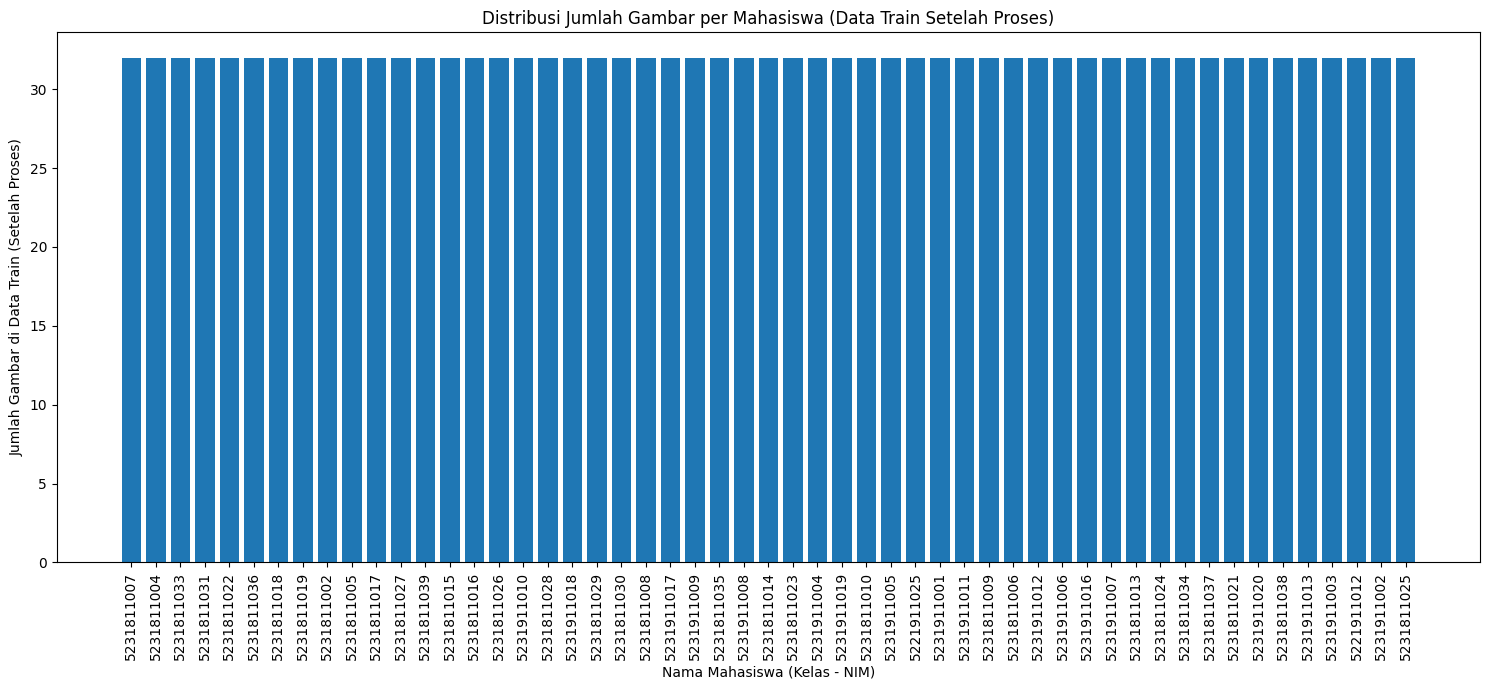


Semua mahasiswa memiliki jumlah gambar yang sama di Data Train (setelah proses).


In [37]:
# Sort classes by count for better visualization
if processed_train_class_counts:
    sorted_processed_class_counts = dict(sorted(processed_train_class_counts.items(), key=lambda item: item[1]))

    # Plot class distribution for processed data
    plt.figure(figsize=(15, 7))
    plt.bar(sorted_processed_class_counts.keys(), sorted_processed_class_counts.values())
    plt.xticks(rotation=90)
    plt.xlabel("Nama Mahasiswa (Kelas - NIM)") # Use NIM as class name
    plt.ylabel("Jumlah Gambar di Data Train (Setelah Proses)")
    plt.title("Distribusi Jumlah Gambar per Mahasiswa (Data Train Setelah Proses)")
    plt.tight_layout()
    plt.show()

    # Check if all class counts are the same after processing
    if len(processed_train_class_counts) > 0:
        first_count_processed = list(processed_train_class_counts.values())[0]
        all_counts_same_processed = all(count == first_count_processed for count in processed_train_class_counts.values())

        if all_counts_same_processed:
            print("\nSemua mahasiswa memiliki jumlah gambar yang sama di Data Train (setelah proses).")
        else:
            print("\nJumlah gambar per mahasiswa di Data Train (setelah proses) bervariasi.")
    else:
        print("\nTidak ada data kelas yang ditemukan di Data Train (setelah proses) untuk diperiksa distribusinya.")

else:
    print("\nTidak ada data kelas yang ditemukan di Data Train (setelah proses) untuk diperiksa distribusinya.")

### **2.7. Visualize Sample Images (Visualisasi Sampel Gambar)**

**Penjelasan:** Menampilkan beberapa gambar acak dari direktori training yang sudah diproses beserta label (NIM) mereka untuk melihat hasil dari proses deteksi dan pemotongan wajah.

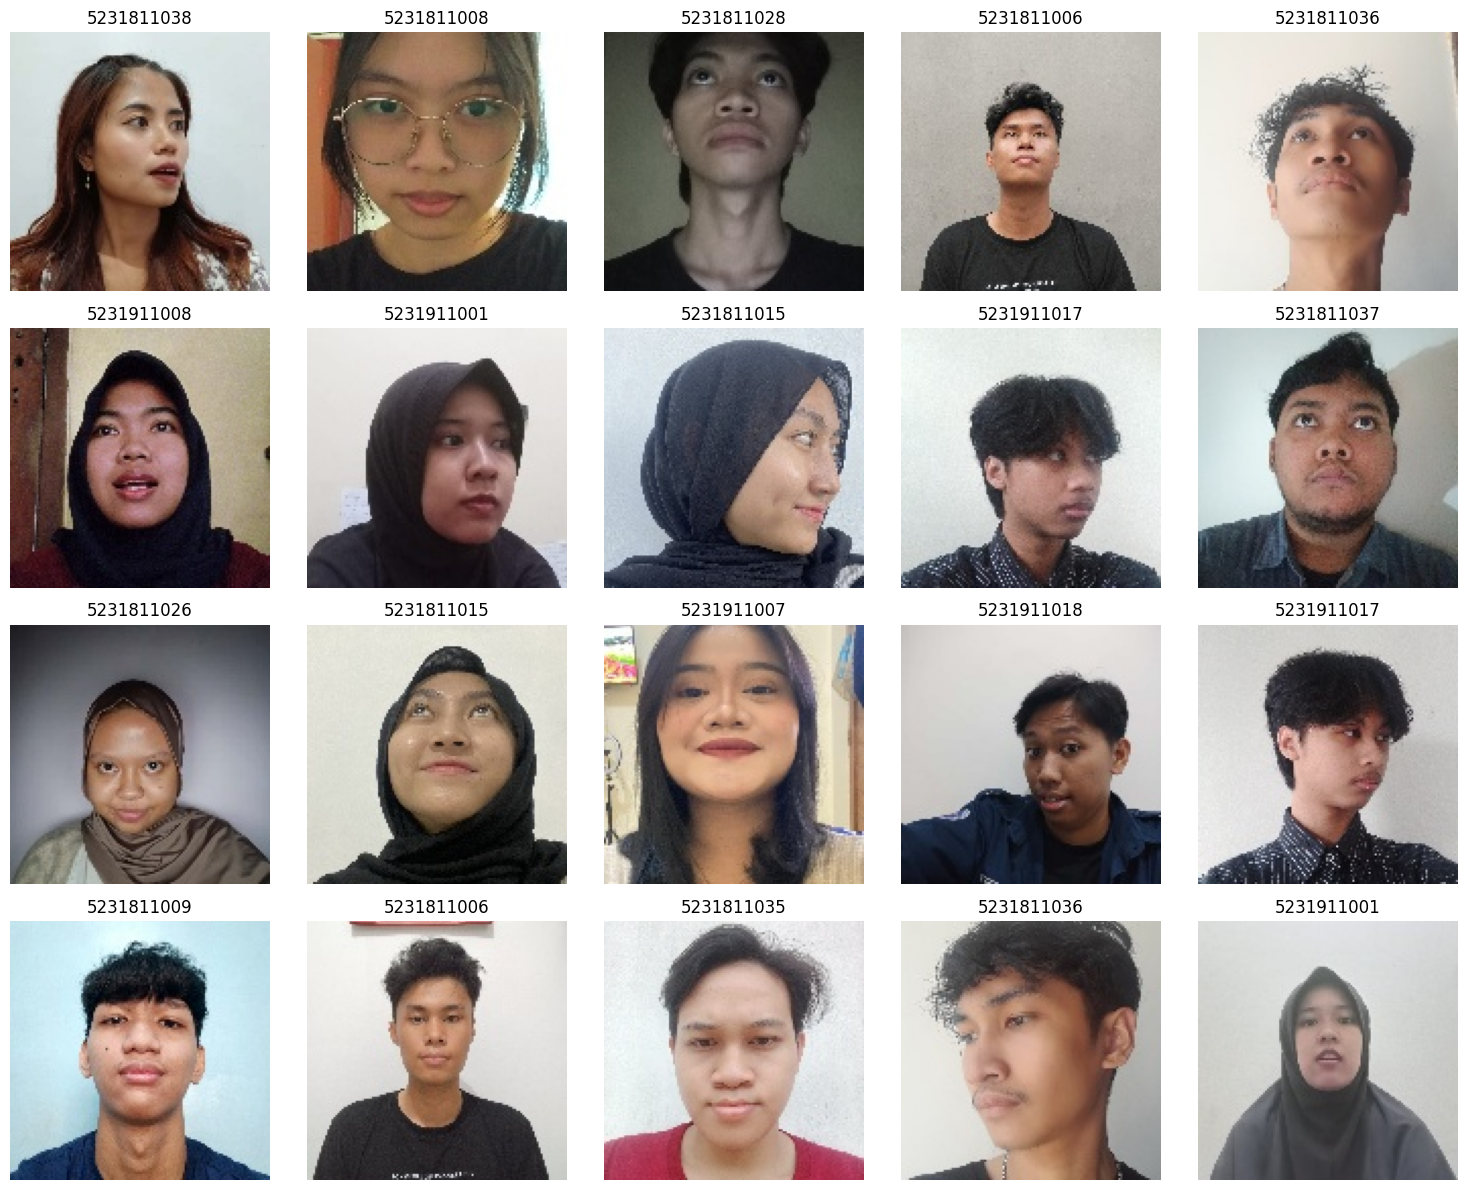

In [38]:
plt.figure(figsize=(15, 12)) # Adjust figure size for more images
# Get all image files from the processed training directory
all_processed_train_images = glob.glob(os.path.join(PROCESSED_TRAIN_DIR, '*', '*.jpg'))

# Check if there are enough images
num_samples_to_display = min(20, len(all_processed_train_images)) # Display up to 20 samples
if num_samples_to_display == 0:
    print("Tidak ada gambar di direktori training yang sudah diproses untuk ditampilkan.")
else:
    # Select random images
    sample_images_paths_processed = np.random.choice(all_processed_train_images, size=num_samples_to_display, replace=False)

    for i, img_path in enumerate(sample_images_paths_processed):
        plt.subplot(4, 5, i + 1) # Adjust subplot grid to 4 rows and 5 columns
        img = plt.imread(img_path) # imread in matplotlib reads as RGB
        plt.imshow(img)

        # Extract class name (NIM) from directory name
        class_name_processed = os.path.basename(os.path.dirname(img_path))

        plt.title(class_name_processed)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

## **Section 3: Data Loading and Augmentation (Pemuatan dan Augmentasi Data)**

**Penjelasan:** Sekarang kita akan bekerja dengan data yang sudah bersih di `PROCESSED_PATH`. Karena datanya sudah memiliki struktur folder per kelas, kita bisa menggunakan `flow_from_directory` yang lebih efisien dari Keras `ImageDataGenerator`.

### **3.1. Create Data Generators (Membuat Generator Data)**

**Penjelasan:** Inisialisasi `ImageDataGenerator` untuk training dengan augmentasi (rescale, rotation, shift, zoom, flip) dan satu lagi untuk testing (hanya rescale). Rescaling (membagi nilai piksel dengan 255) penting untuk normalisasi data gambar.

In [39]:
# Data Augmentation for Training Data
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values to [0, 1]
    rotation_range=20, # Rotate images by up to 20 degrees
    width_shift_range=0.2, # Shift images horizontally
    height_shift_range=0.2, # Shift images vertically
    zoom_range=0.2, # Randomly zoom into images
    horizontal_flip=True, # Randomly flip images horizontally
    fill_mode='nearest' # Fill in missing pixels after augmentations
)

# Only rescale for Test Data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255) # Normalize pixel values

### **3.2. Apply the Generators (Menerapkan Generator)**

**Penjelasan:** Membuat `train_generator` menggunakan `train_datagen.flow_from_directory()` yang menunjuk ke `PROCESSED_PATH/train` dan `test_generator` menggunakan `test_datagen.flow_from_directory()` yang menunjuk ke `PROCESSED_PATH/test`. Generator ini akan secara otomatis memuat gambar dan label (dari nama folder).

In [ ]:
# Create training data generator
train_generator = train_datagen.flow_from_directory(
    PROCESSED_TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH), # Resize images to target size
    batch_size=BATCH_SIZE,
    class_mode='categorical', # For multi-class classification
    color_mode='rgb' # Ensure images are treated as color images
)

# Create validation/test data generator
test_generator = test_datagen.flow_from_directory(
    PROCESSED_TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH), # Resize images to target size
    batch_size=BATCH_SIZE,
    class_mode='categorical', # For multi-class classification
    color_mode='rgb', # Ensure images are treated as color images
    shuffle=False # Do not shuffle test data to evaluate consistently
)

# Update NUM_CLASSES based on the number of classes found by the generator
NUM_CLASSES = train_generator.num_classes

print(f"\nNumber of classes identified by generators: {NUM_CLASSES}")
print(f"Class indices: {train_generator.class_indices}")